#remarque:
le sentiment analysis correspond à la génération des labels pour chaque avis.( apres avoir extrait les features de chaque avis)

rque: view les captures de remarques dans messenger : a inclure peut etre dans presentation

Sentiment Analysis & Modeling
# Objectif : Générer des labels de sentiment et entraîner des modèles ML.

In [22]:
%pip install textblob-fr
import pandas as pd
import string
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import joblib

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Charger le dataset nettoyé
df = pd.read_csv('cleaned_hotel_reviews.csv')
print("Dataset chargé :", df.shape)
print(df.head())

Dataset chargé : (201, 1)
                                      processed_text
0  ['hôtel', 'exceptionnel', 'cœur', 'tun', 'reco...
1  ['bonjour', 'écris', 'fair', 'part', 'immens',...
2  ['vérit', 'hont', 'l’hôteller', 'tunisien', 'c...
3  ['excellent', 'séjour', 'business', 'hôtel', '...
4  ['tres', 'bon', 'hôtel', 'tres', 'propr', 'ser...


In [ ]:
# Génération des labels de sentiment
# On utilise TextBlob-FR pour analyser le sentiment de chaque avis
def get_sentiment(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 'Neutral'
    analysis = TextBlob(text, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
    score = analysis.sentiment[0]  # polarité entre -1 et 1
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'
    

df['sentiment'] = df['processed_text'].apply(lambda x: get_sentiment(' '.join(eval(x))))
print("\nRépartition des sentiments :")
print(df['sentiment'].value_counts())



Répartition des sentiments :
sentiment
Positive    120
Neutral      74
Negative      7
Name: count, dtype: int64


In [20]:
df.to_csv('cleaned_hotel_reviews_labelled.csv', index=False, encoding='utf-8')
print("Dataset avec labels sauvegardé !")

Dataset avec labels sauvegardé !


In [23]:
# TF-IDF features
# Chaque liste de tokens est reconvertie en string pour vectorization.
texts = df['processed_text'].apply(lambda x: ' '.join(eval(x))).astype(str)
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(texts)
y = df['sentiment'].values

print("TF-IDF shape:", X.shape)

TF-IDF shape: (201, 993)


# Modèles ML a tester
# Nous allons entraîner trois modèles et évaluer avec K-Fold (Stratified pour conserver la proportion de classes) :
# - Logistic Regression  
# - Multinomial Naive Bayes  
# - SVM (Linear)

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "SVM (Linear)": SVC(kernel='linear')
}

# K-Fold Cross Validation



=== Logistic Regression ===
Accuracy scores: [0.63414634 0.7        0.675      0.675      0.65      ]
Mean accuracy: 0.6668292682926829

=== Multinomial Naive Bayes ===
Accuracy scores: [0.58536585 0.65       0.65       0.625      0.6       ]
Mean accuracy: 0.6220731707317073

=== SVM (Linear) ===
Accuracy scores: [0.70731707 0.725      0.65       0.65       0.675     ]
Mean accuracy: 0.6814634146341463

 Meilleur modèle : SVM (Linear) avec accuracy moyenne = 0.6815

Accuracy (tout dataset): 0.9751
F1-score (weighted): 0.9713

Classification report :
              precision    recall  f1-score   support

    Negative       1.00      0.43      0.60         7
     Neutral       0.97      0.99      0.98        74
    Positive       0.98      1.00      0.99       120

    accuracy                           0.98       201
   macro avg       0.98      0.81      0.86       201
weighted avg       0.98      0.98      0.97       201



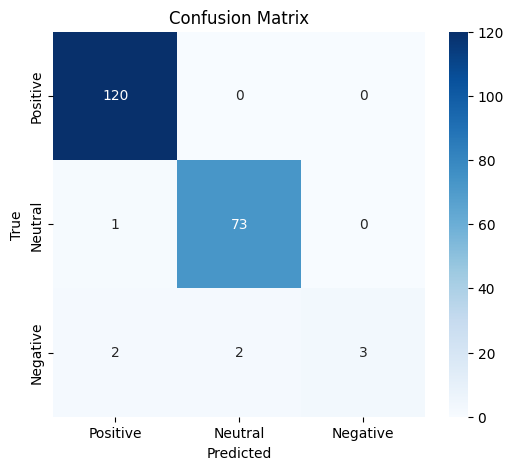


Modèle et TF-IDF vectorizer sauvegardés !


In [27]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionnaire pour stocker les scores moyens
mean_scores = {}

# Évaluer chaque modèle
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    mean_scores[name] = scores.mean()
    print(f"\n=== {name} ===")
    print("Accuracy scores:", scores)
    print("Mean accuracy:", scores.mean())

# Sélection du meilleur modèle
best_model_name = max(mean_scores, key=mean_scores.get)
print(f"\n Meilleur modèle : {best_model_name} avec accuracy moyenne = {mean_scores[best_model_name]:.4f}")

# Entraîner le meilleur modèle sur tout le dataset
best_model = models[best_model_name]
best_model.fit(X, y)

# Prédictions sur tout le dataset pour évaluation
y_pred = best_model.predict(X)

# Metrics
acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='weighted')  # weighted F1 pour prendre en compte déséquilibre éventuel
print(f"\nAccuracy (tout dataset): {acc:.4f}")
print(f"F1-score (weighted): {f1:.4f}")
print("\nClassification report :")
print(classification_report(y, y_pred))

# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=['Positive', 'Neutral', 'Negative'])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Positive', 'Neutral', 'Negative'], 
            yticklabels=['Positive', 'Neutral', 'Negative'], cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Sauvegarder modèle et vectorizer
joblib.dump(best_model, 'best_sentiment_model.pkl')
joblib.dump(tfidf_vect, 'tfidf_vectorizer.pkl')
print("\nModèle et TF-IDF vectorizer sauvegardés !")


# Justification du choix des metrics

Accuracy

Définition : proportion de prédictions correctes sur l’ensemble des données.

Pourquoi : Pour un dataset équilibré (ou relativement équilibré) de sentiments (Positive / Negative / Neutral), l’accuracy donne une mesure simple et intuitive de performance globale.

Pourquoi pas uniquement F1-score ou confusion matrix ici ?

F1-score est utile surtout si les classes sont très déséquilibrées.

Ici, comme on a un dataset moyen avec 3 classes, l’accuracy donne un premier repère clair.

On pourra compléter avec classification_report pour inspecter précision/rappel/F1 par classe si besoin.

K-Fold Cross-Validation

Permet d’évaluer le modèle de manière robuste, en réduisant le risque que la performance soit due au hasard sur un split particulier.

Le StratifiedKFold maintient la proportion des classes dans chaque fold.

# Justification des métriques choisies :

Accuracy : mesure globale de la proportion de prédictions correctes. Simple et intuitive, adaptée ici car les classes sont relativement équilibrées.

F1-score (weighted) : prend en compte à la fois la précision et le rappel, pondéré par la taille de chaque classe. Utile si certaines classes (ex : Negative) sont moins représentées.

Classification report : détail par classe pour voir précision, rappel et F1-score individuellement.

Confusion matrix : permet de visualiser quelles classes sont confondues, utile pour comprendre les erreurs du modèle.

# Vue globale sur les avis existants

sentiment
Positive    120
Neutral      74
Negative      7
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_22844\2916545338.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')


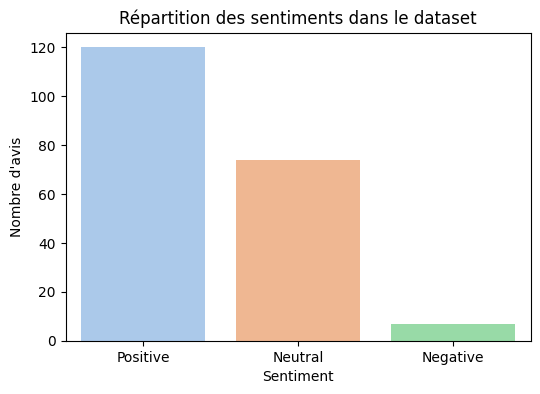

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compter le nombre d'avis par sentiment
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Visualisation
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')
plt.title("Répartition des sentiments dans le dataset")
plt.ylabel("Nombre d'avis")
plt.xlabel("Sentiment")
plt.show()


Note: you may need to restart the kernel to use updated packages.
sentiment
Positive    120
Neutral      74
Negative      7
Name: count, dtype: int64


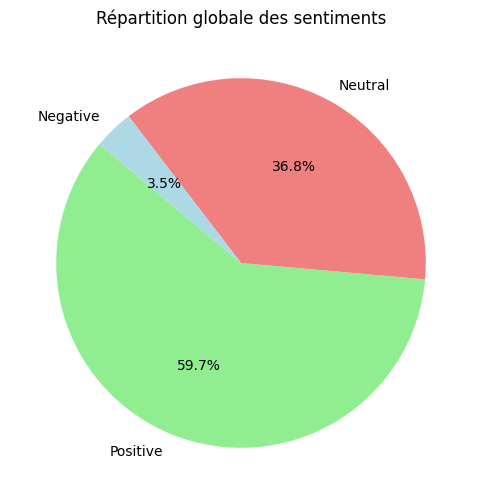

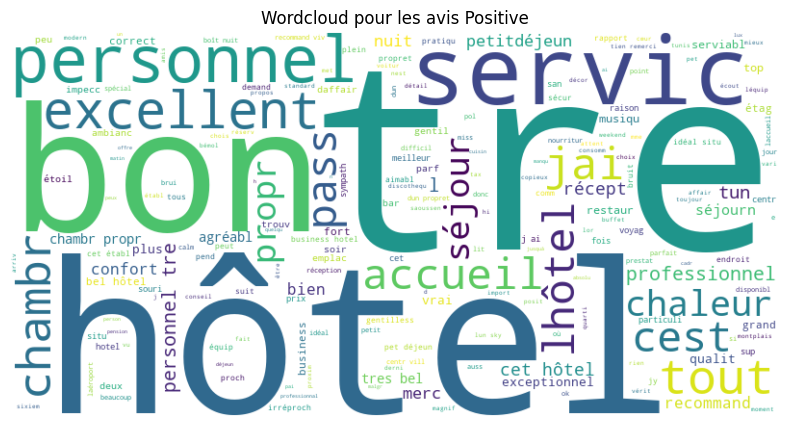

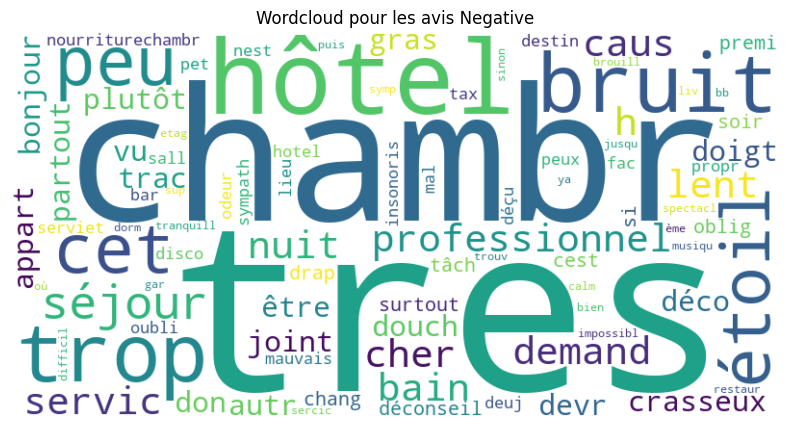

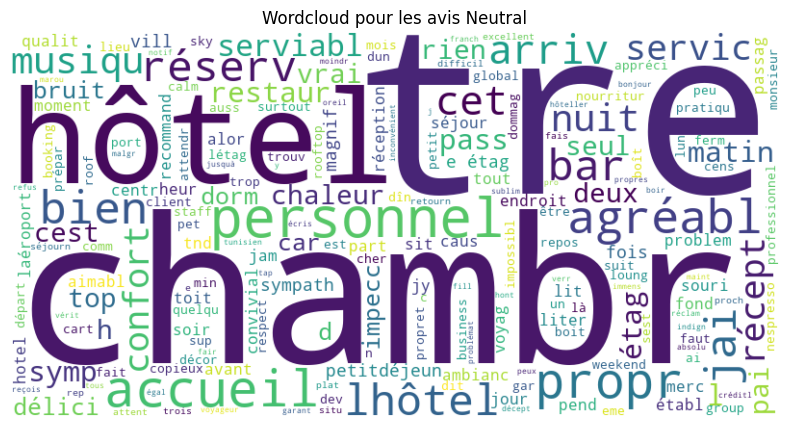

In [29]:
#visualisation des sentiments
%pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Distribution des sentiments
sent_counts = df['sentiment'].value_counts()
print(sent_counts)

# Pie chart
plt.figure(figsize=(6,6))
colors = ['lightgreen', 'lightcoral', 'lightblue']
plt.pie(sent_counts, labels=sent_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Répartition globale des sentiments")
plt.show()

# Wordcloud par sentiment
for sentiment in ['Positive', 'Negative', 'Neutral']:
    text = ' '.join([' '.join(eval(doc)) for doc in df[df['sentiment']==sentiment]['processed_text']])
    if text.strip():  # éviter wordcloud vide
        wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Wordcloud pour les avis {sentiment}")
        plt.show()


# test sur des avis nv

In [ ]:
# Exemples de nouveaux avis
new_reviews = [
    "L'hôtel était magnifique et le personnel très accueillant.",
    "Chambre sale et service déplorable, je ne recommande pas.",
    "Séjour correct mais rien d'exceptionnel."
]

# Prétraitement identique
def preprocess_text(text):
    tokens = process_review(text)
    return ' '.join(tokens)

new_texts = [preprocess_text(r) for r in new_reviews]

# TF-IDF transformation
X_new = tfidf_vect.transform(new_texts)

# Prédiction
predictions = best_model.predict(X_new)
for review, pred in zip(new_reviews, predictions):
    print(f"Review: {review}\nPredicted sentiment: {pred}\n")
